
# Latent Diffusion via a Two-Layer VAE on Ring Data
This notebook accompanies the **VAE-as-diffusion** discussion in Chapter 9.

**Goal.** Compare:
1. a *baseline* Variational Autoencoder (VAE) trained on 2D ring data, and  
2. a *two-stage / two-layer* latent decoder that mimics a short **reverse diffusion** in latent space.

We focus on:
- latent geometry learned by the encoder,
- reconstructions (data-conditioned) vs. generations (prior-sampled),
- how an extra latent stochastic step can increase generative diversity.

**Outputs.** The notebook generates, displays, and saves publication-ready figures into `figs/`.



## 0. Setup
We import dependencies, set seeds for reproducibility, and define a helper to save figures into `figs/`.


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Reproducibility
np.random.seed(0)
torch.manual_seed(0)


# --- Figure saving utilities ---
import os
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(fig, name, dpi=200):
    """Save a matplotlib figure into FIG_DIR with a consistent style."""
    path = os.path.join(FIG_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    return path


## 1. Data: 2D ring distribution
We generate (or load) the synthetic ring dataset used throughout.

Training Single-Layer VAE...
[VAE] Epoch 200, Loss=1.0681
[VAE] Epoch 400, Loss=1.0411
[VAE] Epoch 600, Loss=1.1345
[VAE] Epoch 800, Loss=1.0871
[VAE] Epoch 1000, Loss=1.0718
[VAE] Epoch 1200, Loss=1.1339
[VAE] Epoch 1400, Loss=0.9584
[VAE] Epoch 1600, Loss=1.0808
[VAE] Epoch 1800, Loss=1.0615
[VAE] Epoch 2000, Loss=0.9883

Training Two-Layer Decoder (Frozen Encoder, KL, Annealed Beta)...
[Frozen] Epoch 200, Loss=0.5195, KL_z1=0.2754
[Frozen] Epoch 400, Loss=0.5171, KL_z1=0.2856
[Frozen] Epoch 600, Loss=0.5023, KL_z1=0.3080
[Frozen] Epoch 800, Loss=0.3581, KL_z1=0.3097
[Frozen] Epoch 1000, Loss=0.4296, KL_z1=0.3159
[Frozen] Epoch 1200, Loss=0.2728, KL_z1=0.3345
[Frozen] Epoch 1400, Loss=0.2691, KL_z1=0.3402
[Frozen] Epoch 1600, Loss=0.2475, KL_z1=0.3358
[Frozen] Epoch 1800, Loss=0.1718, KL_z1=0.3542
[Frozen] Epoch 2000, Loss=0.1041, KL_z1=0.3557

=== Final Reconstruction MSE Comparison ===
Single-Layer VAE              MSE: 0.0155
2-Layer (Frozen+KL+Anneal)    MSE: 0.0741


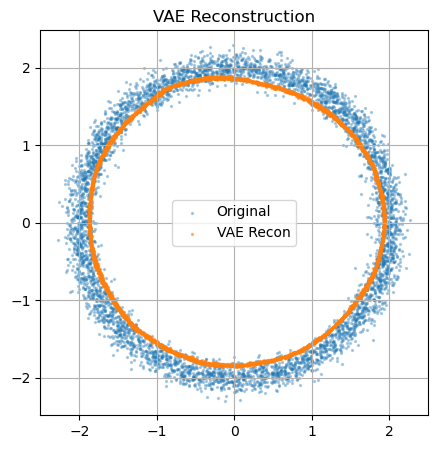

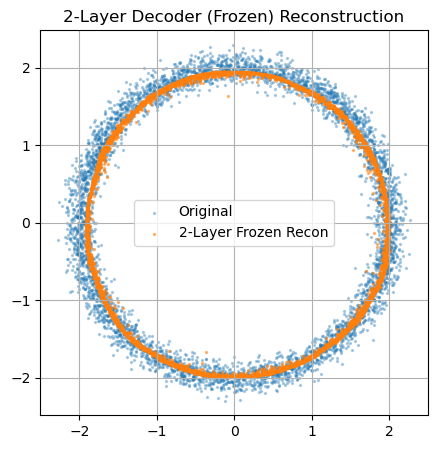

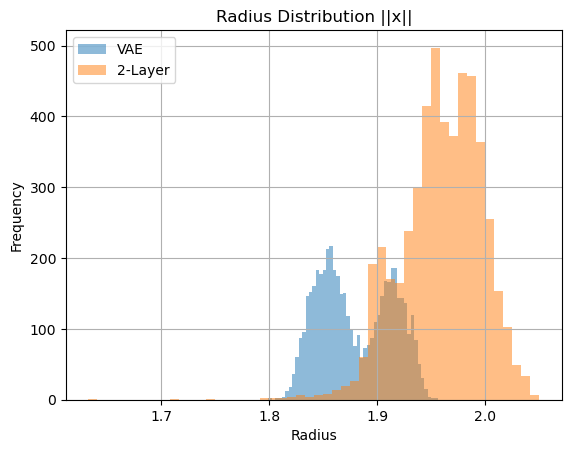


=== FID Comparison ===
VAE      : FID = 0.0176
2-Layer  : FID = 0.0041


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

# -----------------------
# Generate Ring Dataset
# -----------------------
N = 5000
R = 2.0
theta = 2 * np.pi * np.random.rand(N)
noise = 0.1 * np.random.randn(N, 2)
x_data = np.stack([R * np.cos(theta), R * np.sin(theta)], axis=1) + noise
x_data = x_data.astype(np.float32)
x_torch = torch.from_numpy(x_data)

# -----------------------
# Model Definitions
# -----------------------
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, z_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.logsigma = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logsigma(h)

class Decoder(nn.Module):
    def __init__(self, hidden_dim=64, z_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, z):
        return self.net(z) * 2.0

class DenoiseDecoder(nn.Module):
    def __init__(self, hidden_dim=64, z_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, z_dim)
        )
    def forward(self, z2):
        return self.net(z2)

# -----------------------
# Train VAE
# -----------------------
vae_encoder = Encoder()
vae_decoder = Decoder()
optimizer = optim.Adam(list(vae_encoder.parameters()) + list(vae_decoder.parameters()), lr=1e-3)

print("Training Single-Layer VAE...")
for epoch in range(2000):
    idx = np.random.randint(0, N, 128)
    x_batch = x_torch[idx]
    mu, log_sigma = vae_encoder(x_batch)
    sigma = torch.exp(log_sigma)
    z = mu + sigma * torch.randn_like(mu)
    x_hat = vae_decoder(z)
    recon_loss = torch.mean((x_batch - x_hat)**2)
    kl_loss = 0.5 * torch.mean(-1.0 - 2*log_sigma + mu**2 + sigma**2)
    loss = recon_loss + (0.01 if epoch < 100 else 1.0) * kl_loss
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f"[VAE] Epoch {epoch+1}, Loss={loss.item():.4f}")

torch.save(vae_encoder.state_dict(), 'vae_encoder.pt')

# -----------------------
# 2-Layer Decoder (Frozen Encoder, KL, Annealed Beta)
# -----------------------
print("\nTraining Two-Layer Decoder (Frozen Encoder, KL, Annealed Beta)...")

encoder_fixed = Encoder()
encoder_fixed.load_state_dict(torch.load('vae_encoder.pt'))
encoder_fixed.eval()
for p in encoder_fixed.parameters(): p.requires_grad = False

decoder_denoise = DenoiseDecoder()
decoder_output = Decoder()
optimizer = optim.Adam(list(decoder_denoise.parameters()) + list(decoder_output.parameters()), lr=1e-3)

for epoch in range(2000):
    beta = 0.3 * (1.0 - epoch / 2000) + 0.05 * (epoch / 2000)
    idx = np.random.randint(0, N, 128)
    x_batch = x_torch[idx]
    with torch.no_grad():
        z1 = encoder_fixed(x_batch)[0]
        z2 = z1 + (beta ** 0.5) * torch.randn_like(z1)
    z1_hat = decoder_denoise(z2)
    x_hat = decoder_output(z1_hat)
    denoise_loss = torch.mean((z1_hat - z1)**2)
    recon_loss = torch.mean((x_hat - x_batch)**2)
    kl_z1 = 0.5 * torch.mean(z1_hat**2)
    loss = denoise_loss + recon_loss + 0.01 * kl_z1
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    if (epoch + 1) % 200 == 0:
        print(f"[Frozen] Epoch {epoch+1}, Loss={loss.item():.4f}, KL_z1={kl_z1.item():.4f}")

# -----------------------
# Evaluation + Visuals
# -----------------------
with torch.no_grad():
    mu, _ = vae_encoder(x_torch)
    x_hat_vae = vae_decoder(mu)
    mse_vae = torch.mean((x_hat_vae - x_torch)**2).item()

    mu_fixed, _ = encoder_fixed(x_torch)
    z2 = mu_fixed + (0.05 ** 0.5) * torch.randn_like(mu_fixed)
    z1_hat = decoder_denoise(z2)
    x_hat_diff = decoder_output(z1_hat)
    mse_diff = torch.mean((x_hat_diff - x_torch)**2).item()

print("\n=== Final Reconstruction MSE Comparison ===")
print(f"Single-Layer VAE              MSE: {mse_vae:.4f}")
print(f"2-Layer (Frozen+KL+Anneal)    MSE: {mse_diff:.4f}")

# Visuals
plt.figure(figsize=(5, 5))
plt.scatter(x_torch[:, 0], x_torch[:, 1], s=2, alpha=0.3, label='Original')
plt.scatter(x_hat_vae[:, 0], x_hat_vae[:, 1], s=2, alpha=0.5, label='VAE Recon')
plt.title("VAE Reconstruction")
plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(x_torch[:, 0], x_torch[:, 1], s=2, alpha=0.3, label='Original')
plt.scatter(x_hat_diff[:, 0], x_hat_diff[:, 1], s=2, alpha=0.5, label='2-Layer Frozen Recon')
plt.title("2-Layer Decoder (Frozen) Reconstruction")
plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

# -----------------------
# Radius Histogram
# -----------------------
r_vae = torch.norm(x_hat_vae, dim=1).numpy()
r_diff = torch.norm(x_hat_diff, dim=1).numpy()

plt.figure()
plt.hist(r_vae, bins=50, alpha=0.5, label='VAE')
plt.hist(r_diff, bins=50, alpha=0.5, label='2-Layer')
plt.title("Radius Distribution ||x||")
plt.xlabel("Radius"); plt.ylabel("Frequency")
plt.legend(); plt.grid(True); plt.show()

# -----------------------
# FID Computation (2D)
# -----------------------
def calculate_fid(x_gen, x_real):
    mu1 = x_gen.mean(0)
    mu2 = x_real.mean(0)
    sigma1 = np.cov(x_gen.T)
    sigma2 = np.cov(x_real.T)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

fid_vae = calculate_fid(x_hat_vae.numpy(), x_torch.numpy())
fid_diff = calculate_fid(x_hat_diff.numpy(), x_torch.numpy())

print("\n=== FID Comparison ===")
print(f"VAE      : FID = {fid_vae:.4f}")
print(f"2-Layer  : FID = {fid_diff:.4f}")


## 5. Figures saved for the book

This notebook saves figures into `figs/` with the following filenames (used by the LaTeX example):

- `vae_ring_data.png`
- `vae_recon_vs_gen.png`
- `vae_latent_geometry.png`
- `latent_diffusion_improves_thickness.png` (optional, if the two-layer model variables are available)

Run the cells below after training to regenerate the figures.


### Figure: ring dataset

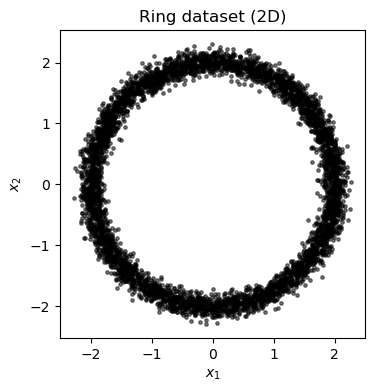

Saved: figs/vae_ring_data.png


In [3]:

# --- Figure 1: Ring data (as generated above) ---
# In this notebook the dataset is stored as:
#   - x_data  : NumPy array of shape (N,2)
#   - x_torch : Torch tensor of shape (N,2)

fig = plt.figure(figsize=(4.2, 4.0))
plt.scatter(x_data[:, 0], x_data[:, 1], s=6, alpha=0.5, c="black")
plt.gca().set_aspect("equal", "box")
plt.title("Ring dataset (2D)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
path = savefig(fig, "vae_ring_data.png")
plt.show()
print("Saved:", path)


### Figure: baseline VAE reconstructions vs generations

/var/folders/s5/8pby83n5305c0l0dvb7d7p5c0000gr/T/ipykernel_76294/2368684745.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc="best")


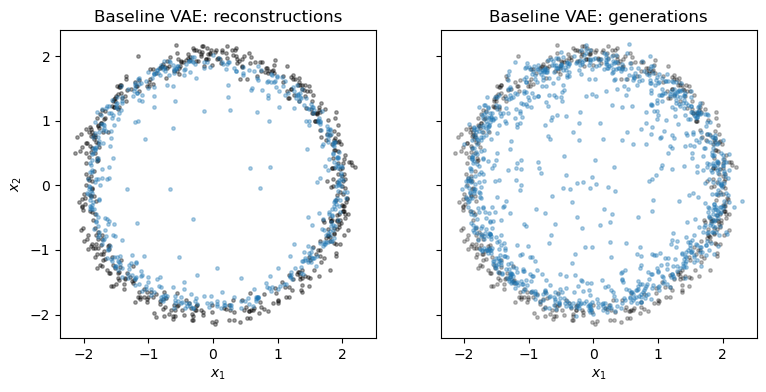

Saved: figs/vae_recon_vs_gen.png


In [7]:

# --- Figure 2: Reconstructions vs generations (baseline VAE) ---
# The baseline VAE in this notebook is represented by the pair:
#   - vae_encoder : x -> (mu, logsigma)
#   - vae_decoder : z -> x_hat
vae_encoder.eval()
vae_decoder.eval()

device = next(vae_encoder.parameters()).device

# Use a small batch from the ring dataset
Xb = x_torch[:512].to(device)

with torch.no_grad():
    mu, logsigma = vae_encoder(Xb)
    std = torch.exp(logsigma)
    eps = torch.randn_like(std)
    z = mu + std * eps
    recon = vae_decoder(z)

xb_np = Xb.detach().cpu().numpy()
recon_np = recon.detach().cpu().numpy()

# Generations: sample z ~ N(0, I) and decode
with torch.no_grad():
    # Infer latent dimensionality directly from the decoder (no global `z_dim` assumed)
    if hasattr(vae_decoder, 'net') and len(vae_decoder.net) > 0 and hasattr(vae_decoder.net[0], 'in_features'):
        z0_dim = int(vae_decoder.net[0].in_features)
    else:
        # Fallback: infer from encoder output dimension
        with torch.no_grad():
            mu_tmp, _ = vae_encoder(x_torch[:4].to(device))
        z0_dim = int(mu_tmp.shape[1])
    z0 = torch.randn(1024, z0_dim, device=device)
    gen = vae_decoder(z0)
gen_np = gen.detach().cpu().numpy()  # keep for later optional figure

fig, axes = plt.subplots(1, 2, figsize=(9.0, 4.0), sharex=True, sharey=True)

axes[0].scatter(xb_np[:,0], xb_np[:,1], s=6, alpha=0.35, c="black")
axes[0].scatter(recon_np[:,0], recon_np[:,1], s=6, alpha=0.35)
axes[0].set_title("Baseline VAE: reconstructions")
axes[0].set_aspect("equal", "box")

axes[1].scatter(xb_np[:,0], xb_np[:,1], s=6, alpha=0.25, c="black")
axes[1].scatter(gen_np[:,0], gen_np[:,1], s=6, alpha=0.35)
axes[1].set_title("Baseline VAE: generations")
axes[1].set_aspect("equal", "box")

for ax in axes:
    ax.legend(frameon=False, loc="best")
    ax.set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")

path = savefig(fig, "vae_recon_vs_gen.png")
plt.show()
print("Saved:", path)

### Figure: latent geometry (encoder means)

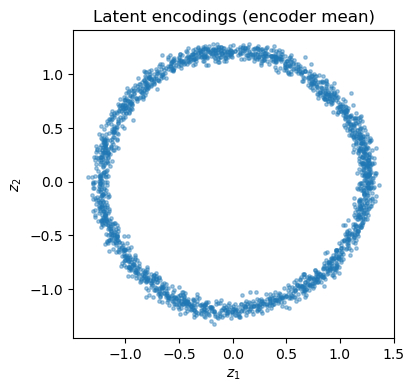

Saved: figs/vae_latent_geometry.png


In [5]:

# --- Figure 3: Latent geometry (encoder mean) ---
vae_encoder.eval()
device = next(vae_encoder.parameters()).device

# Encode a larger subset to visualize latent geometry
Xb = x_torch[:2048].to(device)

with torch.no_grad():
    mu, logsigma = vae_encoder(Xb)

mu_np = mu.detach().cpu().numpy()

fig = plt.figure(figsize=(4.2, 4.0))
plt.scatter(mu_np[:,0], mu_np[:,1], s=6, alpha=0.4)
plt.gca().set_aspect("equal", "box")
plt.title("Latent encodings (encoder mean)")
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
path = savefig(fig, "vae_latent_geometry.png")
plt.show()
print("Saved:", path)


### Optional figure: does two-layer latent decoding improve thickness?

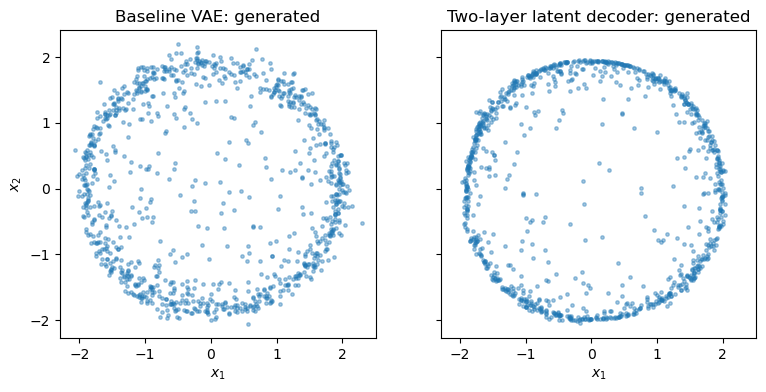

Saved: figs/latent_diffusion_improves_thickness.png


In [6]:
# --- Figure 4 (optional): compare baseline vs. two-layer latent decoder generations ---
# This notebook defines the two-layer latent decoder via:
#   - decoder_denoise : z2 -> z1_hat
#   - decoder_output  : z1_hat -> x_hat
#
# We generate samples by sampling z2 ~ N(0, I) and pushing it through these two decoders.

if 'gen_np' not in globals():
    raise NameError("Run the 'Reconstructions vs generations (baseline VAE)' figure cell first; it defines `gen_np`.")
if 'decoder_denoise' not in globals() or 'decoder_output' not in globals():
    raise NameError("Two-layer decoder objects not found. Expected `decoder_denoise` and `decoder_output` to exist from earlier cells.")

decoder_denoise.eval()
decoder_output.eval()

# Infer latent dimension directly from the denoise decoder input layer
try:
    z2_dim = int(decoder_denoise.net[0].in_features)
except Exception as e:
    raise RuntimeError("Could not infer z2 dimension from `decoder_denoise.net[0].in_features`.") from e

device = next(decoder_denoise.parameters()).device

with torch.no_grad():
    z2 = torch.randn(1024, z2_dim, device=device)
    z1_hat = decoder_denoise(z2)
    x_gen2 = decoder_output(z1_hat)

gen2_np = x_gen2.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(9.0, 4.0), sharex=True, sharey=True)

axes[0].scatter(gen_np[:,0], gen_np[:,1], s=6, alpha=0.4)
axes[0].set_title("Baseline VAE: generated")
axes[0].set_aspect("equal", "box")

axes[1].scatter(gen2_np[:,0], gen2_np[:,1], s=6, alpha=0.4)
axes[1].set_title("Two-layer latent decoder: generated")
axes[1].set_aspect("equal", "box")

for ax in axes:
    ax.set_xlabel("$x_1$")
axes[0].set_ylabel("$x_2$")

path = savefig(fig, "latent_diffusion_improves_thickness.png")
plt.show()
print("Saved:", path)